In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)
print('hms_string function initialized')

hms_string function initialized


In [2]:
# necessary library files
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
print('libraries loaded')

# set up few parameter run GAN 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

libraries loaded


In [19]:
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = r'G:\Uppsala Docs\GAN\Faces_Images'
EPOCHS = 300
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [20]:
# generate binary data to be used for training
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

start = time.time()
print("Loading training images...")

training_data = []
faces_path = os.path.join(DATA_PATH,'images')
for filename in tqdm(os.listdir(faces_path)):
    path = os.path.join(faces_path,filename)
    image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.
print('Training Data Shape',np.array(training_data).shape)

print("Saving training image binary...")
np.save(training_binary_path,training_data)
elapsed = time.time()-start
print (f'Image preprocess time: {hms_string(elapsed)}')

Loading training images...


100%|█████████████████████████████████████████████████████████████████████████████| 7864/7864 [00:31<00:00, 246.79it/s]


Training Data Shape (7864, 96, 96, 3)
Saving training image binary...
Image preprocess time: 0:01:01.17


In [21]:
# if binary data already generated then load it
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Loading previous training pickle...")
training_data = np.load(training_binary_path)

Loading previous training pickle...


In [22]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print('Training Data Shape',np.array(training_data).shape)

Training Data Shape (7864, 96, 96, 3)


In [23]:
# generator network
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
        model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

# discriminator network
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

print('Initialized Discrminator and generator network')

Initialized Discrminator and generator network


In [24]:
# to save seed images after each epoch
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = generated_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

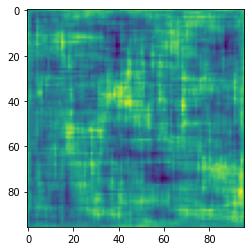

In [25]:
# test generator network
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0]) # display an image single color channel

In [26]:
# test discriminator network
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49995983]], shape=(1, 1), dtype=float32)


In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()
# loss calculating functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

print('Initialized loss calculating functions')

generator_optimizer = tf.keras.optimizers.Adam(0.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.5e-4,0.5)

Initialized loss calculating functions


In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator,discriminator.trainable_variables))
    return gen_loss,disc_loss

print('Initialzed train step')

Initialzed train step


In [29]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
    start = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
        save_images(epoch,fixed_seed)
    
    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

print('Initialzed train')

Initialzed train


In [30]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.7383859157562256,disc loss=0.8462979197502136, 0:07:59.13
Epoch 2, gen loss=2.469226360321045,disc loss=0.6236435174942017, 0:07:37.92
Epoch 3, gen loss=2.8733067512512207,disc loss=0.5015000700950623, 0:07:42.05
Epoch 4, gen loss=3.193446636199951,disc loss=0.4496272802352905, 0:07:38.93
Epoch 5, gen loss=3.0633907318115234,disc loss=0.5034997463226318, 0:07:37.95
Epoch 6, gen loss=2.6627869606018066,disc loss=0.6189758777618408, 0:07:38.25
Epoch 7, gen loss=2.41852068901062,disc loss=0.6413607597351074, 0:07:38.24
Epoch 8, gen loss=2.398448944091797,disc loss=0.6460356116294861, 0:07:36.44
Epoch 9, gen loss=2.4110910892486572,disc loss=0.6613874435424805, 0:07:37.51
Epoch 10, gen loss=2.426330089569092,disc loss=0.6359638571739197, 0:07:36.18
Epoch 11, gen loss=2.4882006645202637,disc loss=0.6107664108276367, 0:07:37.75
Epoch 12, gen loss=2.5163166522979736,disc loss=0.6226850152015686, 0:07:36.76
Epoch 13, gen loss=2.5388355255126953,disc loss=0.5905854105949402,

Epoch 106, gen loss=4.761190891265869,disc loss=0.24385446310043335, 0:07:45.30
Epoch 107, gen loss=4.754393577575684,disc loss=0.22008582949638367, 0:07:47.58
Epoch 108, gen loss=4.748985767364502,disc loss=0.24076208472251892, 0:07:45.42
Epoch 109, gen loss=4.73557186126709,disc loss=0.21997468173503876, 0:07:51.47
Epoch 110, gen loss=4.771082401275635,disc loss=0.23303993046283722, 0:07:44.45
Epoch 111, gen loss=4.8941216468811035,disc loss=0.23794004321098328, 0:07:44.78
Epoch 112, gen loss=4.792380332946777,disc loss=0.22443148493766785, 0:07:45.54
Epoch 113, gen loss=4.771778106689453,disc loss=0.22099369764328003, 0:07:45.06
Epoch 114, gen loss=4.785426139831543,disc loss=0.24323530495166779, 0:07:49.62
Epoch 115, gen loss=4.849946022033691,disc loss=0.22536061704158783, 0:07:47.38
Epoch 116, gen loss=4.87816858291626,disc loss=0.22770291566848755, 0:07:46.52
Epoch 117, gen loss=4.8656907081604,disc loss=0.2179061770439148, 0:07:46.08
Epoch 118, gen loss=4.858039379119873,disc l

KeyboardInterrupt: 

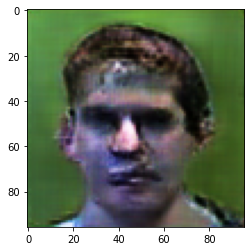

In [44]:
# test generator network
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

# change range from [-1,1] back to [0,255]
x = np.asarray(generated_image[0, :, :])
normalized_images = (x-x.min())/(x.max()-x.min())
plt.imshow(normalized_images)

In [34]:
generator.save(os.path.join(DATA_PATH,'FaceGAN_Generator'))

INFO:tensorflow:Assets written to: G:\Uppsala Docs\GAN\Faces_Images\FaceGAN_Generator\assets
